In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import pickle as pkl
import os

In [2]:
# plots setup
sns.set_palette("Set2")
sns.set_context(context="paper", font_scale=2)

mpl.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "font.size": 22,
    }
)
use_pgf = True
plt.rcParams["text.usetex"] = True
hatches=['x',"o","/","\\"]

In [3]:
# loading dataset
df=pd.read_csv("requests.csv",index_col=0)
df["time"]=df["time"].apply(lambda t:datetime.fromisoformat(t))
print(df.head())
print(df.info())

                 time  requests
0 2013-10-31 23:00:00        66
1 2013-11-01 00:00:00        48
2 2013-11-01 01:00:00        44
3 2013-11-01 02:00:00        46
4 2013-11-01 03:00:00        50
<class 'pandas.core.frame.DataFrame'>
Index: 1464 entries, 0 to 1463
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   time      1464 non-null   datetime64[ns]
 1   requests  1464 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 34.3 KB
None


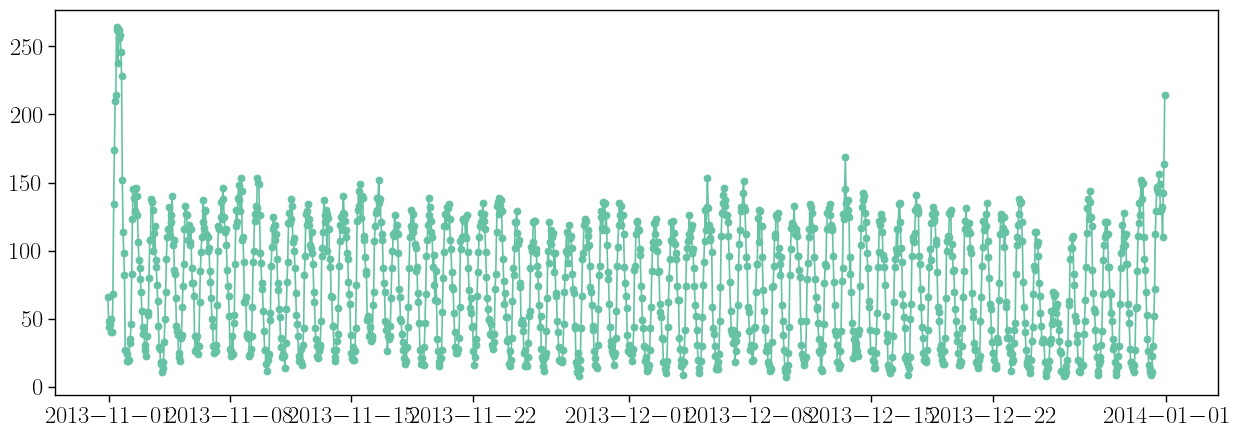

In [4]:
# plotting dataset
plt.figure(figsize=(15,5))
plt.plot(df["time"],df["requests"],color='C0')
plt.scatter(df["time"],df["requests"])

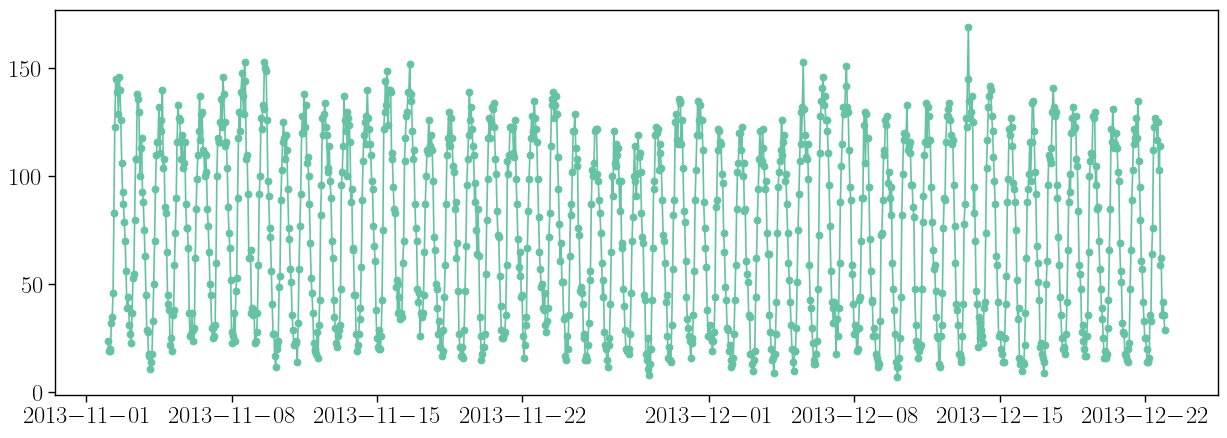

In [5]:
# removing outliers
df=df[(df["time"]>"2013-11-02") & (df["time"]<"2013-12-23")]
# plotting dataset
plt.figure(figsize=(15,5))
plt.plot(df["time"],df["requests"],color='C0')
plt.scatter(df["time"],df["requests"])

In [6]:
# train/test split
train_size=21*24
test_size=len(df)-train_size

train_data=df[:train_size].reset_index()
test_data=df[train_size:].reset_index()

train_data.to_csv("train-dataset.csv")
test_data.to_csv("test-dataset.csv")

In [7]:
# scaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

features=["requests"]
scaled_train_data= scaler.fit_transform(train_data[features].values)
scaled_test_data= scaler.transform(test_data[features].values)


In [8]:
# fitting sarima
from statsmodels.tsa.arima.model import ARIMA

sarima_model = ARIMA(
    scaled_train_data,
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 7*24)
).fit()

/home/default/experiments/time-series-benchmark/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


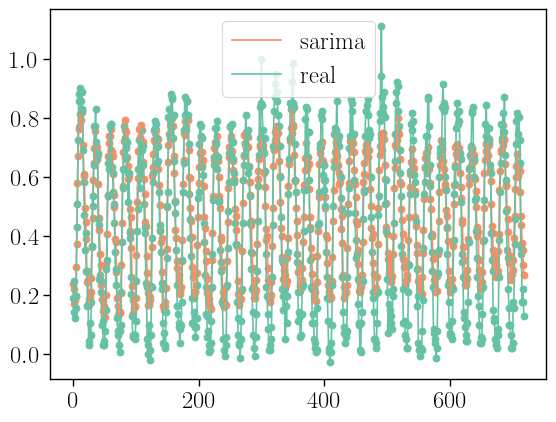

In [9]:
# sarima evaluation
prevision=sarima_model.forecast(steps=test_size)

plt.plot(np.arange(0,test_size,1),prevision, label="sarima",color="C1")
plt.plot(np.arange(0,test_size,1),scaled_test_data, label="real",color="C0")

plt.scatter(np.arange(0,test_size,1),prevision,color="C1")
plt.scatter(np.arange(0,test_size,1),scaled_test_data,color="C0")

plt.legend()
plt.show()

In [10]:
# tensorflow preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM,Conv1D, Dense,Dropout,Flatten

window_size=24

def create_sequence(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size,0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequence(scaled_train_data, window_size)
X_test, y_test = create_sequence(scaled_test_data, window_size)     

2026-01-28 13:39:42.976540: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-28 13:39:43.066231: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-28 13:39:43.145766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769607583.212236  118064 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769607583.231620  118064 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769607583.385170  118064 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [11]:
# fitting lstm
lstm_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32,stateful=False),
    # Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer="adam",loss="mse")
lstm_model.fit(X_train, y_train, epochs=30, validation_split=0.1, batch_size=14, shuffle=False)

2026-01-28 13:39:48.520149: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1328 - val_loss: 0.0718
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0763 - val_loss: 0.0591
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0636 - val_loss: 0.0492
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0519 - val_loss: 0.0379
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0361 - val_loss: 0.0195
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187 - val_loss: 0.0067
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0066
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0063
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0061
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0059
Epoch 11/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0057
Epoch 12/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


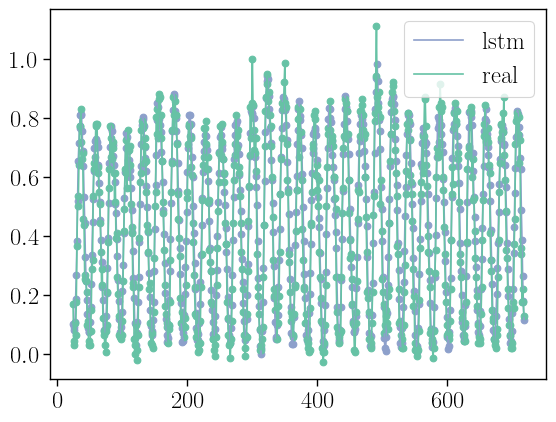

In [13]:
# lstm evaluation
prevision=lstm_model.predict(X_test)

plt.plot(np.arange(window_size,test_size,1),prevision[:,0],label="lstm",color="C2")
plt.plot(np.arange(window_size,test_size,1),y_test,label="real",color="C0")


plt.scatter(np.arange(window_size,test_size,1),prevision[:,0],color="C2")
plt.scatter(np.arange(window_size,test_size,1),y_test,color="C0")


plt.legend()
plt.show()

In [ ]:
# fitting cnn
cnn_model_1d = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(filters=32,kernel_size=2,activation='relu',),
    Flatten(),
    # Dropout(0.2),
    Dense(1)
])

cnn_model_1d.compile(optimizer="adam",loss="mse")
cnn_model_1d.fit(X_train, y_train, epochs=30, validation_split=0.1, batch_size=14)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0902 - val_loss: 0.0230
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - val_loss: 0.0074
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 11/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 12/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


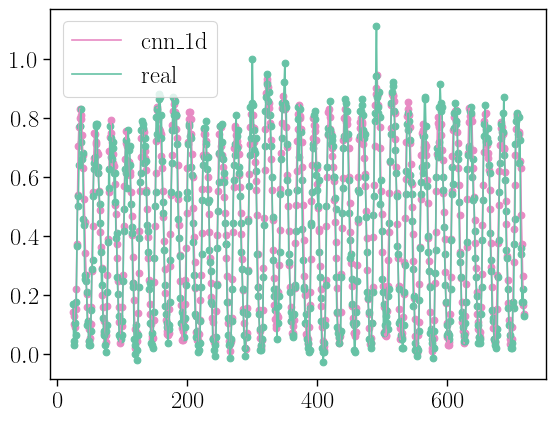

In [15]:
# lstm evaluation
prevision=cnn_model_1d.predict(X_test)

plt.plot(np.arange(window_size,test_size,1),prevision[:,0],label="cnn_1d",color="C3")
plt.plot(np.arange(window_size,test_size,1),y_test,label="real",color="C0")

plt.scatter(np.arange(window_size,test_size,1),prevision[:,0],color="C3")
plt.scatter(np.arange(window_size,test_size,1),y_test,color="C0")


plt.legend()
plt.show()

In [16]:
# saving models
sarima_model.save(os.path.join("models","sarima.pkl"))
lstm_model.save(os.path.join("models","lstm.keras"))
cnn_model_1d.save(os.path.join("models","cnn1d.keras"))

with open(os.path.join("models","scaler.pkl"), 'wb') as file:
    pkl.dump(scaler, file)

In [17]:
# loading models
from statsmodels.tsa.arima.model import ARIMAResults
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os


sarima_loaded=ARIMAResults.load(os.path.join("models","sarima.pkl"))
lstm_loaded=load_model(os.path.join("models","lstm.keras"))
cnn_model_1d=load_model(os.path.join("models","cnn1d.keras"))

In [18]:
# data preprocessing
def create_sequence(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size,0])
    return np.array(X), np.array(y)

window_size=lstm_loaded.input_shape[1]
X_train, y_train = create_sequence(scaled_train_data, window_size)
X_test, y_test = create_sequence(scaled_test_data, window_size)

In [19]:
# recursive forecast
def lstm_recursive_forecast(lstm_model,base_input,steps):
    x_list=base_input.flatten().tolist();
    forecast=[]
    for i in range(steps):
        x=np.array(x_list).reshape((1,24,1))
        y=lstm_model.predict(x).flatten()[0];
        forecast.append(y)
        x_list=x_list[1:]
        x_list.append(y)
        print(x_list)
    return np.array(forecast)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


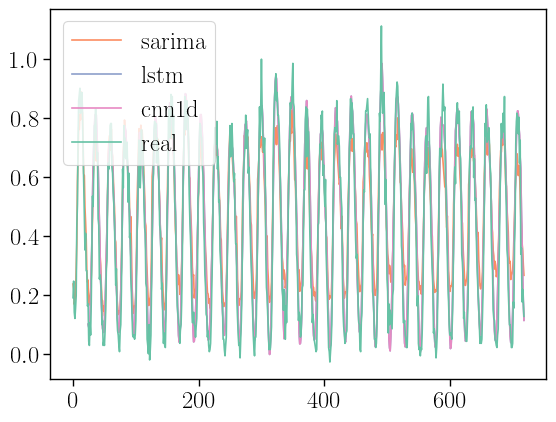

In [20]:
# accuracy comparison
prevision_sarima=sarima_loaded.forecast(steps=test_size)
prevision_lstm=lstm_loaded.predict(X_test)
# prevision_lstm=lstm_recursive_forecast(lstm_loaded,X_test[-1],test_size-window_size)
prevision_cnn=cnn_model_1d.predict(X_test)

plt.plot(np.arange(0,test_size,1),prevision_sarima, label="sarima",color="C1")
plt.plot(np.arange(window_size,test_size,1),prevision_lstm, label="lstm",color="C2")
plt.plot(np.arange(window_size,test_size,1),prevision_lstm, label="cnn1d",color="C3")
plt.plot(np.arange(0,test_size,1),scaled_test_data, label="real",color="C0")

plt.legend()
plt.show()

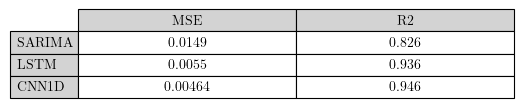

: 

In [ ]:
col_labels=["MSE","R2"]
row_labels=["SARIMA","LSTM","CNN1D"]
cell_text=list(map(lambda r:list(map(lambda c:f"{c:.3g}",r)),[[
    mean_squared_error(scaled_test_data,prevision_sarima),
    r2_score(scaled_test_data,prevision_sarima)
    ],[
    mean_squared_error(scaled_test_data[window_size:],prevision_lstm),
    r2_score(scaled_test_data[window_size:],prevision_lstm)
    ],[
    mean_squared_error(scaled_test_data[window_size:],prevision_cnn),
    r2_score(scaled_test_data[window_size:],prevision_cnn)
    ]]))

fig,ax=plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
table=ax.table(cellText=cell_text,
         cellLoc="center",
         colLabels=col_labels,
         colColours=["lightgray","lightgray"],
         rowLabels=row_labels,
         rowColours=["lightgray","lightgray","lightgray"],
         loc="center")

cell_dict = table.get_celld()
for i in range(len(row_labels)+1):
    for j in range(len(col_labels)):
        if i >0 : 
            cell_dict[(i, -1)].set_height(0.5)
        cell_dict[(i, j)].set_height(0.5)  # Set first row height
fig.tight_layout()
table.set_fontsize(10)
table.scale(1,1)
plt.show()